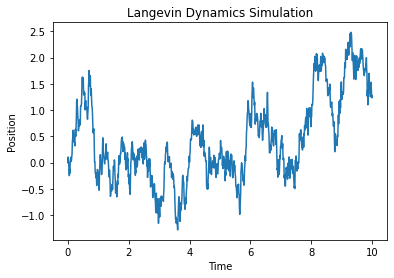

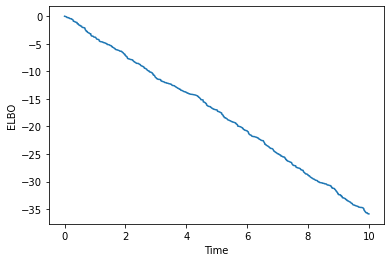

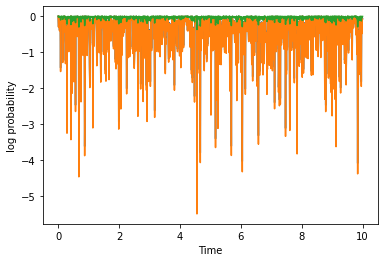

In [3]:
# A demo code of the diffusion model
# Forward process: Langevin sampling dynamics of a given (posterior) distribution p(x)
#                  Diffuse from uniform distribution to p(x)
# Backward process: the score function is approximated via sampling

# Wen-Hao Zhang, wenhao.zhang@utsouthwestern.edu
# Feb 16, 2024
# UT Southwestern, Dallas, TX

import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Parameter of the distribution to be sampled
mu = 0;
sigma = 1;
tau = 1;

# Simulation parameters
dt = 0.01 * tau;
tLen = 10;

# Assemble parameters into a dictionary
ParamDiffusion = {'mu': mu, 'sigma': sigma, 'tau': tau, 'dt': dt};

# --------------------------------------------------
# Define the forward process transition kernel
def logProbForward(x1, x2, Params):
    # Unnormalized forward transition probability
    # x1: current state
    # x2: next state
    
    trans_var = 2 * Params['dt'] / Params['tau'];
    trans_mean = x1 + (Params['mu'] - x1) * Params['dt'] / Params['tau'] / Params['sigma']**2;
    
    logProb = - (x2 - trans_mean)**2 / (2 * trans_var); 
    return logProb;

def logProbBackward(x1, x2, Params):
    # Unnormalized backward transition probability
    # x1: current state
    # x2: next state
    
    trans_var = 2 * Params['dt'] / Params['tau'];
    
    # Approximate gradient of the marginal distribution at time t via sampling
    # p(x_t+1) = \int q(x_t+1 | x_t) p(x_t) dx_t 
    #          \approx q(x_t+1 | \tilde{x}_t), where \tilde{x}_t ~ p(x_t)
    # Therefore \nabla_x_t log p(x_t+1) \approx \nabla_x_t q(x_t+1 | \tilde{x}_t)
    
    gradLogProb_xt = x1 + (Params['mu'] - x1) * Params['dt'] / Params['tau'] / Params['sigma']**2;
    gradLogProb_xt =  - (gradLogProb_xt - x2) / (2 * trans_var);

    trans_mean = x1 + (Params['mu'] - x1) * Params['dt'] / Params['tau'] / Params['sigma']**2;
    trans_mean = trans_mean - np.sqrt(trans_var) * gradLogProb_xt * Params['dt'];
    
    logProb = - (x2 - trans_mean)**2 / (2 * trans_var); 
    return logProb;

# --------------------------------------------------
# Simulate the forward and backward processes

# Initialization
num_steps = int(tLen / dt);
x = np.zeros(num_steps + 1);
ELBO = np.zeros(num_steps + 1);
logProb_Back_array = np.zeros(num_steps + 1);
logProb_Forward_array = np.zeros(num_steps + 1);
x[0] = 0;


# Simulate a Langevin dynamics
for iter in range(0, num_steps):
    dx = sigma**-2 * (mu - x[iter]) / tau * dt + np.sqrt(2/tau * dt) * np.random.normal(0, 1, 1);
    x[iter+1] = x[iter] + dx;
    ELBO[iter+1] = ELBO[iter] + logProbBackward(x[iter], x[iter+1], ParamDiffusion) - logProbForward(x[iter], x[iter+1], ParamDiffusion);
    logProb_Back_array[iter+1] = logProbBackward(x[iter], x[iter+1], ParamDiffusion);
    logProb_Forward_array[iter+1] = logProbForward(x[iter], x[iter+1], ParamDiffusion);
    
# Plot the position over time
plt.plot(np.arange(num_steps+1) * dt, x)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Langevin Dynamics Simulation')
plt.show()

plt.plot(np.arange(num_steps+1) * dt, ELBO)
plt.xlabel('Time')
plt.ylabel('ELBO')
plt.show()


plt.plot(np.arange(num_steps+1) * dt, logProb_Forward_array)
plt.plot(np.arange(num_steps+1) * dt, logProb_Back_array)
plt.plot(np.arange(num_steps+1) * dt, logProb_Back_array - logProb_Forward_array)
plt.xlabel('Time')
plt.ylabel('log probability')
plt.show()

